<a href="https://colab.research.google.com/github/coderacheal/Sunday/blob/Dev/sunday_finetuning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
%pip install transformers

# Importations

In [2]:
#EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

#Deep Learning
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import MobileBertTokenizer, MobileBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Utilities
from google.colab import files
import joblib
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset.csv')
df.head()

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious


In [5]:
df.shape

(937854, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937854 entries, 0 to 937853
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Text      937854 non-null  object
 1   Language  937831 non-null  object
 2   Label     937854 non-null  object
dtypes: object(3)
memory usage: 21.5+ MB


In [7]:
df['Label'].unique()

array(['litigious', 'negative', 'positive', 'uncertainty'], dtype=object)

In [8]:
df['Language'].unique()

array(['en', 'es', 'ca', 'fr', 'pt', 'ja', 'hi', 'ar', 'ko', 'nl', 'et',
       'in', 'und', 'tl', 'zh', 'de', 'cs', 'ru', 'qme', 'it', 'el', 'ro',
       'no', 'tr', 'sv', 'ta', 'fa', 'ht', 'pl', 'da', 'th', 'hu', 'lv',
       'uk', 'qht', 'eu', 'qam', 'si', 'cy', 'zxx', 'ml', 'ne', 'mr',
       'qst', 'vi', 'bn', 'gu', 'is', 'fi', 'ckb', nan, 'te', 'art', 'bg',
       'ur', 'sl', 'lt', 'pa', 'iw', 'kn', 'sr',
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=large')]",
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=large')]",
       'am', 'or',
       "[Photo(previewUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=large')]",
       'sd',
       "[Photo(previewUrl='h

## Use only English Tweets

In [9]:
df = df[df['Language'] == 'en']
df.head()

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
5,It sucks for me since I'm focused on the natur...,en,negative


In [10]:
df.shape

(871310, 3)

In [11]:
df['Language'].unique()

array(['en'], dtype=object)

In [12]:
df = df.drop('Language', axis=1)
df.head()

,Text,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,litigious
3,Rwanda is set to host the headquarters of Unit...,positive
4,OOPS. I typed her name incorrectly (today’s br...,litigious
5,It sucks for me since I'm focused on the natur...,negative


# EDA

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871310 entries, 0 to 937853
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    871310 non-null  object
 1   Label   871310 non-null  object
dtypes: object(2)
memory usage: 19.9+ MB


## Data Cleaning

1. Remove usernames from tweets
2. Remove hashtags from tweets
3. Remove things like http links and \n form tweet

## Let's start with usernames

- We need to remove the usernames that follow the @ symbol. The symbol will be removed as well
- Write a function using the re module

In [14]:
# before
df['Text'][0]

'@Charlie_Corley @Kristine1G @amyklobuchar @StyleWriterNYC testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination'

In [15]:
def remove_usernames(text):
    pattern = r'@\w+\s?'
    result = re.sub(pattern, '', text)
    return result


df['Text'] = df['Text'].apply(remove_usernames)
df

,Text,Label
0,"testimony is NOT evidence in a court of law, s...",litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,litigious
3,Rwanda is set to host the headquarters of Unit...,positive
4,OOPS. I typed her name incorrectly (today’s br...,litigious
5,It sucks for me since I'm focused on the natur...,negative
...,...,...
937849,in the dark. it’s so good,positive
937850,8.SSR &amp; Disha Salian case should be solved...,negative
937851,*ACCIDENT: Damage Only* - Raleigh Fire Depart...,negative
937852,So happy for her! She’s been incredible.,positive


In [16]:
# after
df['Text'][0]

'testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination'

In [17]:
# corresponding label
df['Label'][0]

'litigious'

## Next, hashtags

- We need to remove the hashtags that follow the @ symbol.
- Write a function using the re module

In [18]:
def remove_hastags(text):
    pattern = r'#\w+\s?'
    result = re.sub(pattern, '', text)
    return result


df['Text'] = df['Text'].apply(remove_hastags)
df.head()

,Text,Label
0,"testimony is NOT evidence in a court of law, s...",litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,litigious
3,Rwanda is set to host the headquarters of Unit...,positive
4,OOPS. I typed her name incorrectly (today’s br...,litigious
5,It sucks for me since I'm focused on the natur...,negative


## Next, http links

- We need to remove all http links.
- Write a function using the re module

In [19]:
#before
df['Text'][2]

'https://t.co/YJNiO0p1JV Flagstar Bank discloses a data breach that impacted 1.5\nMillion individuals '

In [20]:
def remove_urls(string):
    pattern = r'https?://\S+'
    result = re.sub(pattern, '', string)
    return result

df['Text'] = df['Text'].apply(remove_urls)

In [21]:
#after there are not more hashtags
df['Text'][2]

' Flagstar Bank discloses a data breach that impacted 1.5\nMillion individuals '


## Remove special characters

- We need to remove * and newline characters (\n).
- Write a function using the re module

In [22]:
#before
df['Text'][2]

' Flagstar Bank discloses a data breach that impacted 1.5\nMillion individuals '

In [23]:
def remove_special_chars(text):
    pattern = r'[*\n]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

df['Text'] = df['Text'].apply(remove_special_chars)
df.head()

,Text,Label
0,"testimony is NOT evidence in a court of law, s...",litigious
2,Flagstar Bank discloses a data breach that im...,litigious
3,Rwanda is set to host the headquarters of Unit...,positive
4,OOPS. I typed her name incorrectly (today’s br...,litigious
5,It sucks for me since I'm focused on the natur...,negative


In [24]:
#after
df['Text'][2]

' Flagstar Bank discloses a data breach that impacted 1.5Million individuals '

# Data Preparation (Feature Engineering)

 - Engineer the litigious label to make it more extensive

In [25]:
litigious_df = df[df['Label'] =='litigious'][:4000]
uncertainty_df = df[df['Label'] =='uncertainty'][:5000]
positive_df = df[df['Label'] =='positive'][:7120]
negative_df = df[df['Label'] =='negative'][:7000]

In [26]:
new_records = []

litigious_sentences = [
    'The plaintiff alleges that the defendant committed defamation by spreading false and damaging statements about their character.',
    'The company is facing a lawsuit for patent infringement due to their unauthorized use of a patented technology.',
    'The accused party is being sued for breach of contract, as they failed to fulfill their obligations as outlined in the signed agreement.',
    'I will bury this place in so much law suit that your grand children are going to need lawyers',
    'The plaintiff claims substantial damages resulting from the defendant\'s fraudulent activities, including misrepresentation of financial information.',
    'The employer is facing a legal battle over allegations of wrongful termination and violation of labor laws, as the employee argues they were fired without just cause.',
    'The plaintiff seeks compensation for the alleged negligence of the defendant, which resulted in personal injury and financial loss.',
    'The company filed a lawsuit against its former employee for alleged misappropriation of trade secrets, claiming significant damages.',
    'The court issued an injunction to prevent the defendant from further trademark violation and ordered them to cease all unauthorized use of the protected mark.',
    'The plaintiff accuses the defendant of libel and slander, claiming that the false statements made by the defendant harmed their personal and professional reputation.',
    'The dispute between the two parties arose from an alleged breach of fiduciary duty, with the plaintiff asserting that the defendant prioritized personal gain over their legal obligations.',
    'The neighbors filed a complaint against each other for alleged trespassing, seeking a restraining order to prevent further disputes.',
    'The landlord is facing a lawsuit from the tenant, claiming breach of contract due to the landlord\'s failure to address necessary repairs in a timely manner.',
    'A legal battle between former spouses ensued over child custody, with both parties accusing each other of parental alienation and seeking sole custody rights.',
    'The homeowners\' association sent a cease and desist letter to a resident for violating community guidelines by conducting business activities from their home.',
    'Siblings engaged in a dispute over their late parent\'s estate, resulting in a contentious probate case with allegations of undue influence and mismanagement of assets.',
    "Amidst the legal proceedings, emotions are running high.",
    "The courtroom echoes with heated arguments and objections.",
    "In the midst of the legal dispute, tension is palpable.",
    "Arguments between the attorneys are becoming increasingly hostile.",
    "The plaintiff's lawyer is aggressively pressing their case.",
    "Legal adversaries are locked in a battle of wits.",
    "The litigation process is complicated and emotionally charged.",
    "In the courtroom, the air is thick with adversarial energy.",
    "A fierce legal struggle is unfolding between the parties.",
    "The litigants are entrenched in a bitter legal conflict.",
    "As the trial progresses, the legal landscape becomes more complex.",
    "Legal representatives are passionately presenting their cases.",
    "The legal teams are locked in a protracted legal battle.",
    "The arbitration process is marked by confrontations and disputes.",
    "A tense legal standoff is playing out in the courtroom.",
    "The plaintiff is seeking substantial damages and restitution.",
    "Emotions are heightened as both parties vehemently argue their positions.",
    "In the courtroom, lawyers clash over key points of contention.",
    "Legal counsel is aggressively pursuing a favorable verdict.",
    "The litigants are embroiled in a contentious legal dispute.",
    "As the trial unfolds, the dispute becomes more intricate.",
    "The defense team vigorously challenges the presented evidence.",
    "Legal adversaries are grappling with the intricacies of the case.",
    "The legal brief lays out a compelling argument for the plaintiff.",
    "The courtroom atmosphere is charged with adversarial energy.",
    "The litigants are entangled in a complex web of legal issues.",
    "The parties involved are locked in a legal battle of wills.",
    "As the trial progresses, legal arguments become more vehement.",
    "The legal teams are fiercely advocating for their respective clients.",
    "The courtroom is a battleground for competing legal narratives.",
    "The litigation process is marked by sharp disagreements and disputes.",
    "The litigants are at odds over the interpretation of the law.",
    "In the midst of the legal wrangling, emotions are running high.",
    "The legal teams are engaged in a fierce battle for victory.",
    "Arguments and objections fill the courtroom as the trial unfolds.",
    "The litigants are entrenched in a legal quagmire.",
    "The legal dispute is reaching a critical juncture in the proceedings.",
    "The defense is vigorously challenging the credibility of the witness.",
    "Legal representatives are presenting compelling arguments before the court.",
    "The courtroom drama is unfolding with intense legal scrutiny.",
    "The litigants are at odds over the interpretation of contractual obligations.",
    "The legal wrangling is creating a tense atmosphere in the courtroom.",
    "The trial is marked by a series of vehement objections from both sides.",
    "As the litigation process unfolds, legal arguments become more complex.",
    "The legal teams are grappling with the intricacies of case law.",
    "The litigants are fiercely contesting the validity of the claims.",
    "Amidst the legal proceedings, both parties stand their ground.",
    "In the courtroom, attorneys vigorously defend their clients' interests.",
    "The legal dispute is characterized by a series of contentious exchanges.",
    "The company is considering legal action and may sue for breach of contract.",
    "The individual is alleging defamation and is contemplating suing for damages.",
    "The plaintiff is suing the defendant for negligence in the personal injury case.",
    "The artist is unhappy with the unauthorized use of their work and may decide to sue.",
    "The corporation is exploring the possibility of suing for patent infringement.",
    "The aggrieved party has consulted with a lawyer about the option of suing for restitution.",
    "The homeowners' association is discussing the potential consequences of suing over property disputes.",
    "In extreme cases, tenants may have grounds for suing landlords for neglect of maintenance.",
    "The consumer is dissatisfied with the product and is threatening to sue for a refund.",
    "The parties involved are in mediation, but if an agreement isn't reached, they may end up suing each other in court.",
]



for i in range(80):
  for sentence in litigious_sentences:
    text = sentence
    label = 'litigious'
    record = {'Text': text, 'Label': label}
    new_records.append(record)


engineered_litigious_df = pd.DataFrame(new_records)



In [27]:
engineered_litigious_df.head()

,Text,Label
0,The plaintiff alleges that the defendant commi...,litigious
1,The company is facing a lawsuit for patent inf...,litigious
2,The accused party is being sued for breach of ...,litigious
3,I will bury this place in so much law suit tha...,litigious
4,The plaintiff claims substantial damages resul...,litigious


In [28]:
new_records = []

positive_sentences = [
    "I love spending time with my family.",
    "The sun is shining, and the weather is perfect.",
    "I accomplished all of my goals today.",
    "Learning new things brings me joy.",
    "My friends are always there for me.",
    "I appreciate the little things in life.",
    "Every day is a new opportunity to be happy.",
    "I'm grateful for the support I receive from others.",
    "I have a lot to look forward to.",
    "I am surrounded by positive influences.",
    "I believe in my abilities and potential.",
    "Good things happen to me every day.",
    "I am proud of myself and my achievements.",
    "I radiate positivity and attract good things.",
    "I am in control of my own happiness.",
    "My life is filled with love and joy.",
    "I am grateful for the abundance in my life.",
    "I am making a positive impact on the world.",
    "I have the power to create change.",
    "My mind is full of positive thoughts.",
    "I am at peace with who I am.",
    "I am capable of handling whatever comes my way.",
    "I am surrounded by love and kindness.",
    "I am a beacon of positivity.",
    "I am deserving of all the good things in life.",
    "I am open to new and exciting possibilities.",
    "I am blessed with good health and vitality.",
    "I am a magnet for success and prosperity.",
    "I am filled with confidence and self-assurance.",
    "I am creating a life I love.",
    "My possibilities are endless.",
    "I am resilient and can overcome challenges.",
    "I attract positive energy into my life.",
    "I choose to be happy and positive.",
    "I am a source of inspiration for others.",
    "I am surrounded by beauty and grace.",
    "I trust the journey even when I don't understand it.",
    "I am becoming a better version of myself every day.",
    "I am full of energy and vitality.",
    "My heart is open to love and kindness.",
    "I am worthy of all the good things life has to offer.",
    "I am surrounded by abundance and prosperity.",
    "I am grateful for the opportunities life presents to me.",
    "I radiate confidence, self-respect, and inner harmony.",
    "I am a source of positive change in the world.",
    "I am thankful for the love that fills my life.",
    "I believe in my dreams and make them a reality.",
    "My positive thoughts create positive experiences."
]

for i in range(60):
  for sentence in positive_sentences:
    text = sentence
    label = 'positive'
    record = {'Text': text, 'Label': label}
    new_records.append(record)

engineered_positive_df = pd.DataFrame(new_records)

In [29]:
engineered_positive_df.head()

,Text,Label
0,I love spending time with my family.,positive
1,"The sun is shining, and the weather is perfect.",positive
2,I accomplished all of my goals today.,positive
3,Learning new things brings me joy.,positive
4,My friends are always there for me.,positive


In [30]:
new_records = []

uncertainty_sentences = [
    "I'm not quite sure what to expect.",
    "There's a lot of uncertainty surrounding this issue.",
    "I'm feeling a bit unsure about the outcome.",
    "It's hard to predict how things will turn out.",
    "I'm on the fence about this decision.",
    "There's a certain level of ambiguity in the situation.",
    "I can't say for certain what the future holds.",
    "I'm not entirely convinced that this is the right approach.",
    "It's a bit unclear what the best course of action is.",
    "I'm feeling a sense of doubt about the whole situation.",
    "There's some hesitancy in my thoughts on this matter.",
    "I'm wavering between different possibilities.",
    "I'm torn between two conflicting ideas.",
    "It's a toss-up as to which option is better.",
    "I'm in a state of indecision right now.",
    "There's a lack of clarity in this matter.",
    "I'm not entirely confident in my judgment here.",
    "I'm grappling with a sense of uncertainty.",
    "It's a bit of a puzzle trying to figure this out.",
    "I'm not completely sold on this idea.",
    "I'm feeling a bit apprehensive about the outcome.",
    "I'm uncertain about the accuracy of this information.",
    "I can't say for sure how this will play out.",
    "There's a degree of unpredictability in this situation.",
    "I'm having second thoughts about my initial stance.",
    "I'm not entirely comfortable with this decision.",
    "It's hard to gauge the likelihood of success.",
    "I'm not entirely convinced that this is the right path.",
    "I'm wrestling with a sense of ambiguity.",
    "I'm feeling a bit uneasy about the future.",
    "I'm not completely clear on the details of the plan.",
    "There's a certain level of doubt creeping in.",
    "I'm having a hard time making up my mind.",
    "It's difficult to determine the best course of action.",
    "I'm on the fence about which option to choose.",
    "There's a certain level of unpredictability in this scenario.",
    "I'm feeling a bit skeptical about the proposed solution.",
    "I'm not entirely sure how to approach this issue.",
    "I'm a bit conflicted about what to do next.",
    "I'm not entirely convinced that this is the right decision.",
    "I'm feeling a sense of unease about the situation.",
    "It's hard to say with certainty what the outcome will be.",
    "I'm wrestling with conflicting thoughts on this matter.",
    "I'm not entirely sure if this is the right path to take.",
    "There's a certain level of ambiguity in my understanding.",
    "I'm feeling a bit hesitant about committing to this.",
    "I'm not completely confident in my assessment of the situation.",
    "It's a bit of a gray area in terms of decision-making.",
    "I'm grappling with a sense of uncertainty about the future.",
    "I just don\'t know"
]


for i in range(100):
  for sentence in uncertainty_sentences:
    text = sentence
    label = 'uncertainty'
    record = {'Text': text, 'Label': label}
    new_records.append(record)


engineered_uncertainty_df = pd.DataFrame(new_records)

In [31]:
engineered_uncertainty_df.head()

,Text,Label
0,I'm not quite sure what to expect.,uncertainty
1,There's a lot of uncertainty surrounding this ...,uncertainty
2,I'm feeling a bit unsure about the outcome.,uncertainty
3,It's hard to predict how things will turn out.,uncertainty
4,I'm on the fence about this decision.,uncertainty


In [32]:
new_records = []

neutral_sentences = [
    "The weather today is quite pleasant.",
    "Coffee is a popular beverage around the world.",
    "Most people prefer a balanced diet for good health.",
    "The annual report provides a comprehensive overview of the company's performance.",
    "It's important to maintain a consistent sleep schedule for overall well-being.",
    "The scientific community continues to explore new frontiers in research.",
    "In mathematics, equations are used to solve problems and describe relationships.",
    "Many cities around the globe are implementing sustainable practices for a greener future.",
    "Reading is a leisure activity enjoyed by people of all ages.",
    "A well-designed website enhances user experience and engagement.",
    "Learning a new language can be a rewarding and challenging experience.",
    "The internet has revolutionized communication and access to information.",
    "Volunteering is a meaningful way to contribute to the community.",
    "Yoga and meditation are popular methods for reducing stress and promoting relaxation.",
    "Public transportation plays a crucial role in urban mobility.",
    "The global economy is influenced by various factors such as trade and technology.",
    "In literature, themes are often explored through characters and plot development.",
    "Healthy communication is essential for successful relationships.",
    "Cultural diversity enriches societies by bringing different perspectives and traditions.",
    "Mobile phones have become an integral part of modern life.",
    "Effective time management is key to achieving personal and professional goals.",
    "Renewable energy sources are gaining importance in the quest for sustainability.",
    "Music is a universal form of expression that transcends language barriers.",
    "The importance of education in shaping future generations cannot be overstated.",
    "Regular exercise is associated with numerous health benefits.",
    "Artificial intelligence is advancing rapidly, influencing various industries.",
    "Nutrition labels on food products provide valuable information for consumers.",
    "Social media platforms connect people from diverse backgrounds and locations.",
    "The principles of democracy emphasize participation and representation.",
    "The study of history allows us to understand the evolution of societies and cultures.",
    "Respecting others' opinions fosters a healthy exchange of ideas.",
    "The process of innovation often involves creativity and problem-solving.",
    "Navigating change requires adaptability and a positive mindset.",
    "Balancing work and personal life is essential for overall well-being.",
    "The use of renewable resources contributes to environmental sustainability.",
    "Effective leadership involves guiding a team toward shared goals.",
    "Mindfulness practices encourage living in the present moment.",
    "Modern architecture reflects both functionality and aesthetic considerations.",
    "The pursuit of knowledge is a lifelong journey.",
    "Global collaboration is essential for addressing pressing issues like climate change.",
    "Coding skills are increasingly valuable in today's technology-driven world.",
    "The concept of fairness is subjective and context-dependent.",
    "Striking a balance between independence and collaboration is important in the workplace.",
    "Economic policies impact the livelihoods of individuals and communities.",
    "Scientific advancements have improved our understanding of the natural world.",
    "The transportation sector plays a pivotal role in economic development.",
    "Maintaining a healthy work-life balance contributes to job satisfaction.",
    "The legal system aims to ensure justice and uphold the rule of law.",
    "Critical thinking skills are valuable in analyzing information and making informed decisions.",
]


for i in range(210):
  for sentence in neutral_sentences:
    text = sentence
    label = 'neutral'
    record = {'Text': text, 'Label': label}
    new_records.append(record)


engineered_neutral_df = pd.DataFrame(new_records)


In [33]:
engineered_neutral_df.head()

,Text,Label
0,The weather today is quite pleasant.,neutral
1,Coffee is a popular beverage around the world.,neutral
2,Most people prefer a balanced diet for good he...,neutral
3,The annual report provides a comprehensive ove...,neutral
4,It's important to maintain a consistent sleep ...,neutral


In [34]:
new_records = []

negative_sentences = [
    "I find myself overwhelmed with stress and pressure on a daily basis.",
    "She can't seem to catch a break lately, and it's taking a toll on her mental well-being.",
    "Despite my best efforts, everything seems to be going wrong at the same time.",
    "In the face of constant challenges, I'm struggling to stay motivated and positive.",
    "As a person who values success, I'm disappointed in the way things have turned out.",
    "Despite the support from others, I'm trapped in a cycle of negativity and self-doubt.",
    "Facing setbacks and obstacles has become a daily struggle, making it hard to see a way forward.",
    "He's constantly criticized, and it's demoralizing to the point where he's losing faith in himself.",
    "We're not satisfied with the direction our lives are heading, and it's causing a sense of despair.",
    "Despite our best intentions, we can't escape the feeling of loneliness and isolation.",
    "With each passing day, the burden of responsibilities feels heavier, and it's overwhelming.",
    "As someone who once believed in endless possibilities, I'm struggling to find meaning in life.",
    "Despite the love and support around, I feel like a burden to those who care about me.",
    "The constant feeling of being stuck in a rut is making it hard to find joy in anything.",
    "Amidst constant rejection and disappointment, it's difficult to stay optimistic about the future.",
    "For someone who once had dreams and aspirations, I'm haunted by past mistakes and regrets.",
    "They are surrounded by people who bring them down, creating a toxic environment.",
    "In the face of a seemingly unending cycle of negativity, finding happiness seems like an impossible task.",
    "Despite efforts to break free from the cycle, I feel like I'm constantly battling against the odds.",
    "She's losing confidence in her ability to overcome challenges and create a fulfilling life.",
    "As someone who once believed in the goodness of people, the constant negativity is disheartening.",
    "In the midst of despair and helplessness, finding a sense of fulfillment is an uphill battle.",
    "Despite efforts to maintain a positive outlook, I find myself constantly on the verge of breaking down.",
    "Amidst the cloud of negativity, it's challenging to see a glimmer of hope for the future.",
    "Feeling constantly overwhelmed, it's hard to see a way out of this cycle of challenges.",
    "Despite attempts to stay positive, each day brings a new wave of difficulties.",
    "Being surrounded by constant negativity, it feels like there's no escape from the gloom.",
    "Amidst the chaos, finding moments of peace and happiness seems like an unattainable goal.",
    "I often question whether I have the strength to endure the ongoing struggles.",
    "In the face of adversity, the once-clear path to success now feels shrouded in uncertainty.",
    "They grapple with a sense of powerlessness in the wake of continuous disappointments.",
    "Despite sincere efforts, it's challenging to shake off the persistent feeling of failure.",
    "For someone who once saw endless possibilities, life now feels like an uphill battle.",
    "With dreams shattered and hopes dashed, the future appears bleak and uninviting.",
    "Fighting against the weight of responsibilities, exhaustion sets in, making progress seem impossible.",
    "Aspirations that once burned bright now flicker in the face of constant setbacks.",
    "The journey, once full of promise, is now marked by obstacles that seem insurmountable.",
    "It feels like happiness is an elusive concept, slipping through my fingers when I reach for it.",
    "Despite outward appearances, internally, there's a constant struggle to find peace.",
    "Haunted by the ghosts of past decisions, regret lingers like a shadow over every thought.",
    "Despite external support, internally, there's a feeling of being lost and disconnected.",
    "They grapple with the heavy burden of expectations, wondering if they'll ever measure up.",
    "Each day feels like a repeat of the last, with no sign of improvement on the horizon.",
    "In a world filled with noise, the silence of disappointment echoes louder than ever.",
    "Despite the facade of strength, there's an inner turmoil that refuses to be silenced.",
    "Struggling with the weight of unmet expectations, the road ahead seems uncertain and daunting.",
    "In the midst of a storm of challenges, finding a moment of calm becomes an impossible task.",
    "The once vibrant colors of life now appear muted, drained by the constant struggles.",
    "They navigate a maze of difficulties, with each turn revealing more obstacles to overcome.",
    "The light at the end of the tunnel feels increasingly distant, obscured by the trials of the journey.",
    "Despite attempts to stay afloat, the waves of adversity threaten to pull me under at every turn."
]


for i in range(60):
  for sentence in negative_sentences:
    text = sentence
    label = 'negative'
    record = {'Text': text, 'Label': label}
    new_records.append(record)


engineered_negative_df = pd.DataFrame(new_records)


In [35]:
engineered_negative_df.head()

,Text,Label
0,I find myself overwhelmed with stress and pres...,negative
1,"She can't seem to catch a break lately, and it...",negative
2,"Despite my best efforts, everything seems to b...",negative
3,"In the face of constant challenges, I'm strugg...",negative
4,"As a person who values success, I'm disappoint...",negative


### Concatenate the original data with engineered columns

In [36]:
df = pd.concat([litigious_df, uncertainty_df, positive_df, negative_df, engineered_litigious_df,
                engineered_uncertainty_df, engineered_neutral_df, engineered_positive_df, engineered_negative_df],
               axis=0, ignore_index=True)


In [37]:
df.head()

,Text,Label
0,"testimony is NOT evidence in a court of law, s...",litigious
1,Flagstar Bank discloses a data breach that im...,litigious
2,OOPS. I typed her name incorrectly (today’s br...,litigious
3,"[When the first sign of surrender comes, Micha...",litigious
4,"""It's Your fight to save the UK from the liars...",litigious


In [38]:
df.shape

(50350, 2)

### Let's shuffle the dataset because of the engineering we did

In [39]:
df = df.sample(frac=1, random_state=42)  # Frac=1 ensures all rows are included, random_state for reproducibility

df.head()

,Text,Label
42923,Navigating change requires adaptability and a ...,neutral
1570,‘“…those which by their very utterance inflict...,litigious
3366,Yeah we had a PM on my last contract and he re...,litigious
45081,My positive thoughts create positive experiences.,positive
15000,"Catalonia is building its own metaverse, says ...",positive


### Visualise data distribution

In [40]:
sentiments = df['Label'].value_counts().sort_values(ascending=False)
sentiments

neutral        10290
negative       10060
litigious      10000
positive       10000
uncertainty    10000
Name: Label, dtype: int64

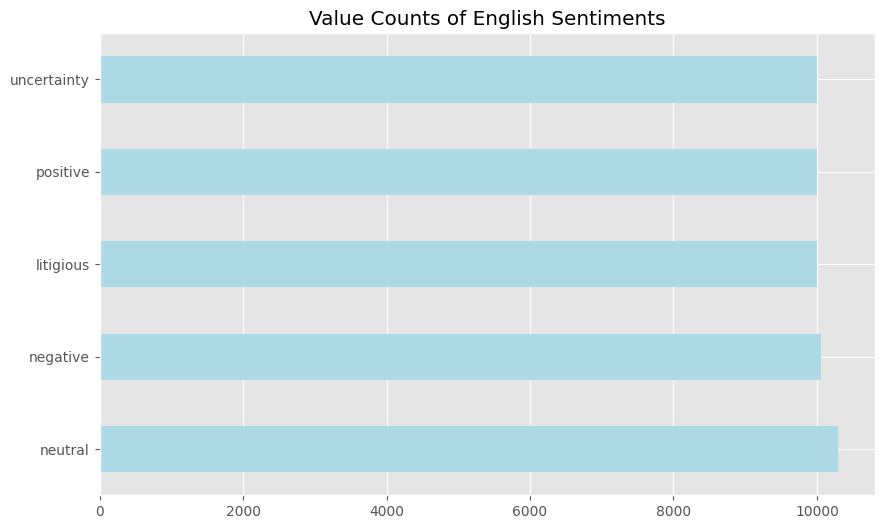

In [41]:
sentiments.plot(kind='barh', color='lightblue', figsize=(10,6))
plt.title('Value Counts of English Sentiments')
plt.show()

# Train Model with 50,000 Tweets and engineered text generated with ChatGPT

#### Prepare and split data

Let's convert our text and label column into list for easy splitting



In [42]:
# Divide dataset into input and output
X = df['Text'].to_list()
y = df['Label'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Encode `Training` and `testing` labels

In [43]:
# Convert training and test labels to numerical format using LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(y_train)
test_labels = label_encoder.transform(y_test)

#Convert labels to PyTorch tensor
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

#### Load the MobileBERT `tokenizer` and model `classifier`

In [44]:
# Load the MobileBERT tokenizer and the MobileBERT model for sequence classification
tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')
model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=5)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize training and evaluation data and create data loaders

In [45]:
# Tokenize the training input data
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512, return_tensors='pt')

#Create data loader for training data
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)

#Create data loader for test data
eval_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)
eval_dataloader = DataLoader(eval_dataset, batch_size=20, shuffle=True)

## Put model in training mode and assess training loss

In [47]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 1

model.train()
for epoch in range(num_epochs):
    training_loss_per_batch = []
    total_training_loss = 0.0

    for batch_count, batch in enumerate(train_dataloader, 1):
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Record the training loss for each batch
        training_loss_per_batch.append(loss.item())
        total_training_loss += loss.item()

        # Print the loss (every 50 batches)
        if batch_count % 50 == 0:
            average_batch_loss = total_training_loss / 50
            print(f"Batch {batch_count}, Average Batch Training Loss: {average_batch_loss}")
            total_training_loss = 0.0

    # Calculate the average training loss for the entire epoch
    if training_loss_per_batch:
        average_epoch_loss = sum(training_loss_per_batch) / len(training_loss_per_batch)
        print(f"Epoch {epoch + 1}, Training Loss for Epoch: {average_epoch_loss}")

Batch 50, Average Batch Training Loss: 537269.1794071579
Batch 100, Average Batch Training Loss: 51.64139176130295
Batch 150, Average Batch Training Loss: 14.64214602470398
Batch 200, Average Batch Training Loss: 8.759161686897277
Batch 250, Average Batch Training Loss: 13.065386843681335
Batch 300, Average Batch Training Loss: 8.24247963666916
Batch 350, Average Batch Training Loss: 2.8960008931159975
Batch 400, Average Batch Training Loss: 2.3399610042572023
Batch 450, Average Batch Training Loss: 4.500320086479187
Batch 500, Average Batch Training Loss: 1.6236696743965149
Batch 550, Average Batch Training Loss: 2.281124155521393
Batch 600, Average Batch Training Loss: 2.871879665851593
Batch 650, Average Batch Training Loss: 5.213638744354248
Batch 700, Average Batch Training Loss: 5.381606462001801
Batch 750, Average Batch Training Loss: 2.5664993381500243
Batch 800, Average Batch Training Loss: 2.5004997730255125
Batch 850, Average Batch Training Loss: 1.874203941822052
Batch 900,

# Evaluate model and assess the validation loss

In [49]:
# Validation loop
model.eval()
predicted_labels = []
predicted_probs = []
actual_labels = []

validation_loss = 0
total_validation_loss = []

with torch.no_grad():
    for batch_count, batch in enumerate(eval_dataloader, 1):
        input_ids, attention_mask, labels = batch

        #Pass evaluation Dataset through the model
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        probabilities = torch.softmax(outputs.logits, dim=1)

        # Record and print the validation loss for each batch along with the batch count
        loss = loss_fn(outputs.logits, labels)
        total_validation_loss.append(loss.item())
        validation_loss += loss.item()

        # Store predicted labels, predicted probabilities, and actual labels
        predicted_labels.extend(predictions.cpu().numpy())
        predicted_probs.extend(probabilities.tolist())
        actual_labels.extend(labels.cpu().numpy())

        # Print the validation loss (every 50 batches)
        if batch_count % 50 == 0:
            average_validation_loss = validation_loss / 50
            print(f"Batch {batch_count}: Average Validation Loss per 50 batches =  {average_validation_loss}")
            validation_loss = 0.0

    # Calculate the average validation loss for the entire epoch
    if total_validation_loss:
        average_epoch_loss = sum(total_validation_loss) / len(total_validation_loss)
        print(f"Validation Loss for Epoch: {average_epoch_loss}")

Batch 50: Average Validation Loss per 50 batches =  0.8760546028614045
Batch 100: Average Validation Loss per 50 batches =  0.917935231924057
Batch 150: Average Validation Loss per 50 batches =  0.8685564970970154
Batch 200: Average Validation Loss per 50 batches =  0.9198213732242584
Batch 250: Average Validation Loss per 50 batches =  0.9013183379173278
Batch 300: Average Validation Loss per 50 batches =  0.9459760534763336
Batch 350: Average Validation Loss per 50 batches =  0.8809878885746002
Batch 400: Average Validation Loss per 50 batches =  0.9456533813476562
Batch 450: Average Validation Loss per 50 batches =  3.63851353764534
Batch 500: Average Validation Loss per 50 batches =  0.8999407398700714
Batch 550: Average Validation Loss per 50 batches =  0.901841186285019
Batch 600: Average Validation Loss per 50 batches =  0.9296066343784333
Batch 650: Average Validation Loss per 50 batches =  0.9278441274166107
Batch 700: Average Validation Loss per 50 batches =  1.01412658929824

## View Classification report

In [50]:
# Invert the predicted and actual labels using the inverse_transform method
actual_labels_inverse = label_encoder.inverse_transform(actual_labels)
predicted_labels_inverse = label_encoder.inverse_transform(predicted_labels)

# Compute and print classification report with original class names
class_report = classification_report(actual_labels_inverse, predicted_labels_inverse, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

# Compute and print confusion matrix with original class names
conf_matrix = confusion_matrix(actual_labels_inverse, predicted_labels_inverse)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

   litigious       0.77      0.84      0.80      3012
    negative       0.43      0.41      0.42      2894
     neutral       0.85      1.00      0.92      3104
    positive       0.58      0.49      0.54      3013
 uncertainty       0.46      0.43      0.44      3082

    accuracy                           0.64     15105
   macro avg       0.62      0.63      0.62     15105
weighted avg       0.62      0.64      0.63     15105

Confusion Matrix:
 [[2530  214   46   38  184]
 [ 416 1183   66  362  867]
 [   0    0 3104    0    0]
 [ 143  599  298 1491  482]
 [ 197  769  138  659 1319]]


## Test Prediction

Let's test a singular sentence to see the sentiment before we evaluate the model

In [53]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_text = "I am going to sue him"
input_encoding = tokenizer(input_text, truncation=True, padding=True, max_length=512, return_tensors='pt')

with torch.no_grad():
    model.eval()

    # Move the model to the device
    model.to(device)

    input_ids = input_encoding['input_ids'].to(device)
    attention_mask = input_encoding['attention_mask'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=1)
    probabilities = torch.softmax(outputs.logits, dim=1)

predicted_label = label_encoder.inverse_transform(predictions.cpu().numpy())[0]
predicted_probability = probabilities[0, predictions[0]].item()

print("Predicted Label:", predicted_label)
print("Predicted Probability:", predicted_probability)

Predicted Label: litigious
Predicted Probability: 0.6685715913772583


# Persist Model

In [48]:
# Save the model and tokenizer in the same folder
model_path = "tuned_sunday_mobile_bert_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# Save label encoder to the same folder
label_encoder_filename = f"{model_path}/label_encoder.joblib"
joblib.dump(label_encoder, label_encoder_filename)

# Create a zip file
!zip -r tuned_sunday_mobile_bert_model.zip $model_path

# Download the zip file
files.download("tuned_sunday_mobile_bert_model.zip")

  adding: tuned_sunday_mobile_bert_model/ (stored 0%)
  adding: tuned_sunday_mobile_bert_model/vocab.txt (deflated 53%)
  adding: tuned_sunday_mobile_bert_model/config.json (deflated 56%)
  adding: tuned_sunday_mobile_bert_model/label_encoder.joblib (deflated 44%)
  adding: tuned_sunday_mobile_bert_model/tokenizer_config.json (deflated 74%)
  adding: tuned_sunday_mobile_bert_model/special_tokens_map.json (deflated 42%)
  adding: tuned_sunday_mobile_bert_model/pytorch_model.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>